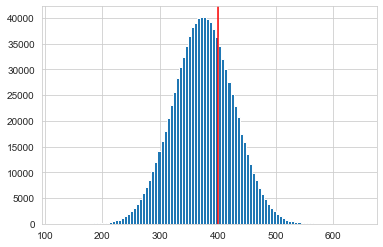

0.690439

In [2]:
#Mock up of Monte Carlo simulation to predict MND diagnosis times

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.stats import kstest

sns.set_style('whitegrid')

#Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
#will dictate what the distributions, mean, SD etc are. 
gp_waiting_times = norm(loc = 14, scale = 5)
gp_to_neuro_referral_time = norm(loc = 180, scale = 30)
investigation_times = norm(loc = 90, scale = 30)
neuro_to_mnd_consultant_times = norm(loc = 90, scale = 30)

#Number of simulations
number_of_simulations = 1000000

#This is the Monte Carlo simulation bit
gp_waiting_times = gp_waiting_times.rvs(number_of_simulations)
gp_to_neuro_referral_time = gp_to_neuro_referral_time.rvs(number_of_simulations)
investigation_times = investigation_times.rvs(number_of_simulations)
neuro_to_mnd_consultant_times = neuro_to_mnd_consultant_times.rvs(number_of_simulations)

#Put it all together in a dataframe
data = pd.DataFrame({
    "gp_waiting_times": gp_waiting_times,
    "gp_to_neuro_referral_time": gp_to_neuro_referral_time,
    "investigation_times": investigation_times,
    "neuro_to_mnd_consultant_times": neuro_to_mnd_consultant_times
})

#Below is the overall equation for calculating the variable of interest
data["total_time"] = (data.gp_waiting_times + data.gp_to_neuro_referral_time + data.investigation_times + data.neuro_to_mnd_consultant_times)

#Plotting the overall distribution of times taken to go through the clinical pathway. Note that we can plot each step.
plt.hist(data.total_time, bins = 100)
plt.axvline(x = 400, c = "r")
plt.show()

#gives probability that someone who goes through this pathway is seen in less than 400 days
data[data["total_time"] < 400].count()["total_time"] / 1000000 

#NEXT STEPS
#How to work in the bottleneck/binary steps, such as "Do I attend the GP?" and "Whats the probability that my
#makes a referral to the neurologist?".

#One solution is to have a parallel pathway, which deals with the binary (yes,no) nodes. Hence instead of a
#distribution of times to reach diagnosis (as above), we will have a distribution of the number of people that
#remain in the pathway. We can multiply the "time to diagnosis" and "number of people" distributions to see what 
#proportion of people are seen within a certain time. 

#The problem with the above is that the results are representative of one iteration of going through the cycle. 
#Patient's who aren't referred by their GP get worse but inevitably go through the cycle again. The model
#above doesn't account for these returners. We could account for this by using if statements to simulate these 
#different scenarios. For example, we have the initial "Do I go to the GP?" node represented by a Bernoulli (binary)
#distribution with 90% yes and 10% no. In the Monte Carlo simulation, if the simulated person is a 'yes', their 
#GP waiting time distribution is drawn from the distribution above; if the simulated person is a 'no', then their
#GP waiting time is drawn from a 'no' distribution, which has a greater mean than the 'yes' distribution (hence
#simulating a longer waiting time). This can be done for all binary and continuous nodes, which might be a better
#way to simulate the process.